## 1. Package load


In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import check_util.checker as checker 
%matplotlib inline

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 1.0.1.post2
GPU 사용 가능 여부: False


## 2. 하이퍼파라미터 세팅


In [8]:
batch_size = 100
num_epochs = 5
learning_rate = 0.001

## 3. Dataset 및 DataLoader 할당


In [9]:
from torch.utils.data import DataLoader

root = './data'
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])
train_data = dset.FashionMNIST(root=root, train=True, transform=transform, download=True)
test_data = dset.FashionMNIST(root=root, train=False, transform=transform, download=True)

train_loader = DataLoader(
    train_data,
    batch_size=100,
    shuffle=True)

test_loader = DataLoader(
    test_data,
    batch_size=100,
    shuffle=False)

## 4. 데이터 샘플 시각화


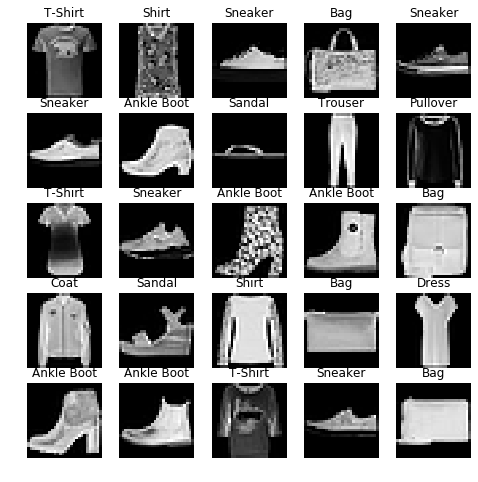

In [11]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}
columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(train_data))
    img = train_data[data_idx][0][0,:,:].numpy() # numpy()를 통해 torch Tensor를 numpy array로 변환
    label = labels_map[train_data[data_idx][1]] # item()을 통해 torch Tensor를 숫자로 변환
    
    fig.add_subplot(rows, columns, i)
    plt.title(label)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

## 5. 네트워크 설계


In [19]:
class DNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(28*28,512),    # First Layer
            nn.BatchNorm1d(512),    # Batch Normalization
            nn.ReLU()     # Use ReLU for Activation Function
        )
        self.layer2 = nn.Sequential(
            nn.Linear(512,10)    # Second Layer
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten
        x_out = self.layer1(x)
        x_out = self.layer2(x_out)
        return x_out

## 6. Weight initialization


In [21]:
def weights_init(m):
    if isinstance(m, nn.Linear): # 모델의 모든 MLP 레이어에 대해서
        nn.init.xavier_normal_(m.weight) # Weight를 xavier_normal로 초기화
        print(m.weight)

## 7. 모델 생성


In [22]:
torch.manual_seed(7777) # 일관된 weight initialization을 위한 random seed 설정
model = DNN().to(device)
model.apply(weights_init) # 모델에 weight_init 함수를 적용하여 weight를 초기화

Parameter containing:
tensor([[ 0.0205,  0.0428,  0.0282,  ..., -0.0033, -0.0147, -0.0342],
        [ 0.0871,  0.0172,  0.0365,  ..., -0.0160,  0.0111, -0.0228],
        [ 0.0533,  0.0007,  0.0012,  ..., -0.0214,  0.0307,  0.0342],
        ...,
        [-0.0039,  0.0030,  0.0070,  ...,  0.0557, -0.0281,  0.0084],
        [ 0.0557,  0.0561, -0.0737,  ...,  0.0119,  0.0440, -0.0253],
        [ 0.0114, -0.0573, -0.0214,  ...,  0.0360,  0.0021,  0.0203]],
       requires_grad=True)
Parameter containing:
tensor([[ 0.0578, -0.0620,  0.0097,  ...,  0.0025, -0.0586, -0.0876],
        [-0.0626,  0.0149,  0.0781,  ...,  0.0642, -0.1264, -0.0073],
        [ 0.0190, -0.0303, -0.0119,  ..., -0.0622,  0.0081,  0.0024],
        ...,
        [ 0.0017, -0.0512, -0.0223,  ..., -0.1189,  0.0555, -0.0026],
        [-0.0321, -0.0273,  0.0709,  ..., -0.1396,  0.0144, -0.0953],
        [-0.0430, -0.0295, -0.0171,  ..., -0.0054,  0.0289,  0.0014]],
       requires_grad=True)


DNN(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)

## 8. Loss function 및 Optimizer 정의


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

## 9. Training


In [32]:
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()   # 초기화
        loss.backward()     # Gradients 계산
        optimizer.step()    # Parameters 업데이트
        ## 코드 종료 ##
        
        _, argmax = torch.max(outputs, 1)
        accuracy = (labels == argmax).float().mean()
        
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(
                epoch+1, num_epochs, i+1, len(train_loader), loss.item(), accuracy.item() * 100))

Epoch [1/5], Step [100/600], Loss: 0.4273, Accuracy: 84.00%
Epoch [1/5], Step [200/600], Loss: 0.4129, Accuracy: 85.00%
Epoch [1/5], Step [300/600], Loss: 0.4045, Accuracy: 87.00%
Epoch [1/5], Step [400/600], Loss: 0.4982, Accuracy: 82.00%
Epoch [1/5], Step [500/600], Loss: 0.3691, Accuracy: 82.00%
Epoch [1/5], Step [600/600], Loss: 0.2761, Accuracy: 90.00%
Epoch [2/5], Step [100/600], Loss: 0.3668, Accuracy: 86.00%
Epoch [2/5], Step [200/600], Loss: 0.5722, Accuracy: 83.00%
Epoch [2/5], Step [300/600], Loss: 0.2059, Accuracy: 91.00%
Epoch [2/5], Step [400/600], Loss: 0.2651, Accuracy: 89.00%
Epoch [2/5], Step [500/600], Loss: 0.1873, Accuracy: 92.00%
Epoch [2/5], Step [600/600], Loss: 0.2290, Accuracy: 92.00%
Epoch [3/5], Step [100/600], Loss: 0.4378, Accuracy: 80.00%
Epoch [3/5], Step [200/600], Loss: 0.3710, Accuracy: 86.00%
Epoch [3/5], Step [300/600], Loss: 0.3863, Accuracy: 85.00%
Epoch [3/5], Step [400/600], Loss: 0.2085, Accuracy: 95.00%
Epoch [3/5], Step [500/600], Loss: 0.403

## 10. Test


In [33]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (imgs, labels) in enumerate(test_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, argmax = torch.max(outputs, 1) # max()를 통해 최종 출력이 가장 높은 class 선택
        total += imgs.size(0)
        correct += (labels == argmax).sum().item()
    
    print('Test accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))

Test accuracy for 10000 images: 88.52%


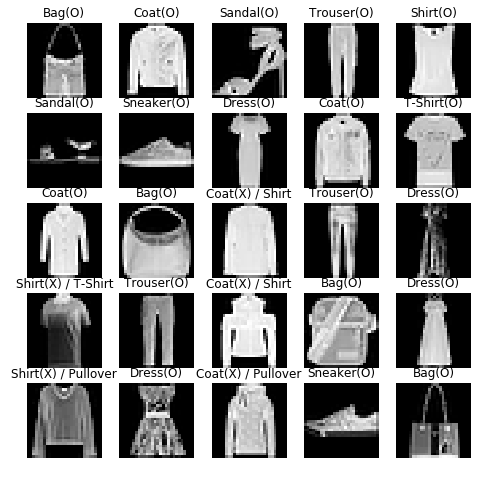

In [34]:
columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_data))
    input_img = test_data[data_idx][0].unsqueeze(dim=0).to(device) 
    
    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = labels_map[argmax.item()]
    label = labels_map[test_data[data_idx][1]]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + '(O)')
    else:
        plt.title(pred + '(X)' + ' / ' + label)
    plot_img = test_data[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap='gray')
    plt.axis('off')
model.train()
plt.show()